In [44]:
import json
import os
from pathlib import Path
from typing import List, Optional, Set

import albumentations as A
import cv2
import numpy as np
import pytorch_lightning as pl
import torch
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


def files_with_ext(folder: str, ext: str) -> List[str]:
    return [str(s) for s in Path(folder).rglob(f"*.{ext}")]


def replace_ext(filenames: List[str], ext: str):
    return [s.replace(f"{Path(s).suffix}", f".{ext}") for s in filenames]


def get_existing_files_with_ext(filenames_set: Set[str], ext: str) -> Set[str]:
    existing = []
    for fn in filenames_set:
        if os.path.isfile(f"{fn}.{ext}"):
            existing.append(fn)

    return set(existing)


def add_extention(filenames: Set[str], ext: str) -> List[str]:
    return [f"{fn}.{ext}" for fn in filenames]


class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def _explain(
        self,
        images: Set[str],
        masks: Set[str],
        verbose: bool,
    ):
        print(f"Found unique image files: {len(images)}")
        print(f"Found unique mask files: {len(masks)}")
        print(f"Found images with annotations: {len(masks.intersection(images))}")
        print(f"Images without annotations: {len(images - masks)}")
        if verbose:
            print(f"{images-masks}")
        print(f"Annotations without images: {len(masks - images)}")
        if verbose:
            print(f"{masks-images}")

    def __init__(
        self,
        image_folder: str,
        mask_folder: str,
        transform=None,
        verbose: bool = True,
        train: bool = True,
    ):
        self.train = train
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        
        images = set([Path(file).name for file in os.listdir(self.image_folder) if file.endswith('.png')])
        masks = set([Path(file).name for file in os.listdir(self.mask_folder) if file.endswith('.png')])
        
        accepted_images = images
        if train:
            accepted_images = images.intersection(masks)
        self._image_names = sorted(
            [i for i in accepted_images],
            key=lambda x: int(Path(x).name.split(".")[0]),
        )

        self._explain(images, masks, verbose=verbose)

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = np.array(image.astype(np.float32) / 255.0, dtype=np.float32)
        return image
    
    @staticmethod
    def read_mask(path: str) -> np.ndarray:
        image = Image.open(path).convert('L')
        return np.asarray(image).astype(np.uint8)

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_name = self._image_names[idx]
        image_path = f"{self.image_folder}/{image_name}"
        mask_path = f"{self.mask_folder}/{image_name}"

        image = self.read_image(image_path)
        mask = self.read_mask(mask_path)
        mask = np.stack([1-mask, mask], axis=-1)

        sample = {"image": image, "mask": mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_names)


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """

    def __init__(
        self, dataset: Dataset, indices: np.ndarray, transform: A.Compose = None
    ):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        returnable = [
            sample["image"],
        ]
        if "mask" in sample.keys():
            # mask = torch.argmax(sample["mask"], dim=0).squeeze()
            returnable.append(sample["mask"])

        return returnable

    def __len__(self) -> int:
        return len(self.indices)


class MaskEyeDataModule(pl.LightningDataModule):
    def __init__(
        self,
        image_folder: str = "path/to/dir",
        mask_folder: str = "path/to/dir",
        batch_size: int = 32,
        train_transform: Optional[A.Compose] = None,
        val_transform: Optional[A.Compose] = None,
        test_size: float = 0.25,
        workers: int = 1,
    ):
        super().__init__()
        self._batch_size = batch_size
        self._dataset = EyeDataset(image_folder=image_folder, mask_folder=mask_folder, transform=None, train=True, verbose=True)
        self.train_transfom = train_transform
        self.val_transfom = val_transform
        self.test_size = test_size
        self.workers = workers

    def setup(self, stage: str):
        train_indices, test_indices = train_test_split(
            range(len(self._dataset)), test_size=self.test_size
        )
        self.dataset_train = DatasetPart(
            self._dataset, train_indices, self.train_transfom
        )
        self.dataset_val = DatasetPart(self._dataset, test_indices, self.val_transfom)

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train, batch_size=self._batch_size, num_workers=self.workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.dataset_val, batch_size=self._batch_size, num_workers=self.workers
        )


In [4]:
ds = MaskEyeDataModule('../data/train_dataset/', '../data/train_dataset_masks/')

Found unique image files: 655
Found unique mask files: 652
Found images with annotations: 652
Images without annotations: 3
{'647.png', '176.png', '257.png'}
Annotations without images: 0
set()


In [45]:
train_dp = EyeDataset('../data/train_dataset/', '../data/train_dataset_masks/', None, True, True)

Found unique image files: 655
Found unique mask files: 652
Found images with annotations: 652
Images without annotations: 3
{'647.png', '176.png', '257.png'}
Annotations without images: 0
set()


# Mixin masks from best predictions

In [33]:
handpicked_ids = [29, 51, 54, 68, 85, 90, 91, 92, 96, 111, 121, 135, 152, 164, 178, 179, 181, 197, 198, 209, 253, 262, 269, 277, 279, 280, 284, 288, 296, 
                  297, 347, 349, 347, 410, 440, 444, 488, 498, 504, 530, 531, 537, 538, 559, 561, 569, 579, 583, 586, 593, 598, 607, 638, 673, 677, 683, 715, 716, 741, 771]

absent_ids = [176, 257, 647]

In [27]:
image_folder = '../data/train_dataset/'
best_pred_masks_folder = '../experiments/20220915-211311/train_data_13/'
orig_masks_folder = '../data/train_dataset_masks/'
target_masks_folder = '../data/train_dataset_mixed_1/'

In [34]:
import shutil
for i in handpicked_ids + absent_ids:
    shutil.copyfile(f"{best_pred_masks_folder}/{i}.png", f"{target_masks_folder}/{i}.png")

In [46]:
mixed_ds = EyeDataset('../data/train_dataset/', '../data/train_dataset_mixed_1/', None, True, True)

Found unique image files: 655
Found unique mask files: 655
Found images with annotations: 655
Images without annotations: 0
set()
Annotations without images: 0
set()


In [37]:
from torchvision.utils import draw_segmentation_masks

def draw_segmask(image: Image.Image, mask: Image.Image, alpha=.8, color=(255,0,0)) -> Image.Image:
    t_image = torch.Tensor(np.asarray(image), device='cpu').type(torch.uint8).permute([2,0,1])
    t_mask = torch.Tensor(np.asarray(mask), device='cpu').type(torch.bool)
    image_with_mask = draw_segmentation_masks(t_image, t_mask, alpha=alpha, colors=color)
    image_with_mask = Image.fromarray(np.moveaxis(image_with_mask.cpu().numpy(), 0, -1))
    return image_with_mask


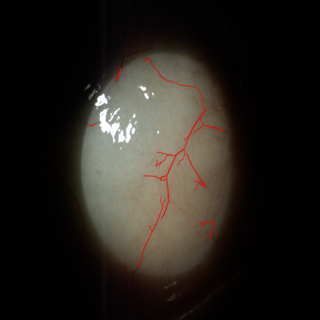

In [43]:
index = absent_ids[2]
image = mixed_ds[index]['image']
mask = mixed_ds[index]['mask']
draw_segmask(Image.fromarray(image), Image.fromarray(mask)).resize([320,320])